In [1]:
!pip install utils
!pip install livelossplot #for Callbacks

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


In [3]:
l={}
for expression in os.listdir("../input/face-expression-recognition-dataset/images/train"):
    print(expression)
    l[expression]=len(os.listdir("../input/face-expression-recognition-dataset/images/train/"+expression))

neutral
sad
disgust
happy
fear
surprise
angry


<BarContainer object of 7 artists>

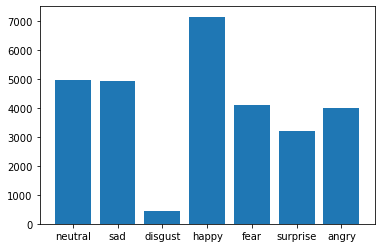

In [4]:
plt.bar(l.keys(), l.values())

In [5]:
img_generator=ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [6]:
train_dir="../input/face-expression-recognition-dataset/images/train/"
valid_dir="../input/face-expression-recognition-dataset/images/validation/"
train_gen=img_generator.flow_from_directory(train_dir,
                                           target_size=(48,48),
                                           color_mode='grayscale',
                                           batch_size=64,
                                           class_mode='categorical',
                                           shuffle=True)
valid_gen=img_generator.flow_from_directory(valid_dir,
                                           target_size=(48,48),
                                           color_mode='grayscale',
                                           batch_size=64,
                                           class_mode='categorical',
                                           shuffle=True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [7]:
model=Sequential()

model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))



model.add(Flatten())



model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7,activation='softmax'))

opt=Adam(lr=0.0005)

model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 128)       0

In [14]:
epoch=15
steps_epochs=train_gen.n//train_gen.batch_size
valid_steps=valid_gen.n//valid_gen.batch_size

checkpoints=ModelCheckpoint(
    "weights.h5", monitor='val_acc', verbose=1,
    save_weights_only=True, mode='max')
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_lr=0.00001)

callbacks=[checkpoints,reduce_lr]

In [ ]:
history=model.fit(
    x=train_gen,
    steps_per_epoch=steps_epochs,
    epochs=epoch,
    validation_data=valid_gen,
    validation_steps=valid_steps,
    callbacks=callbacks
    )

Epoch 1/15
186/450 [===========>..................] - ETA: 16s - loss: 0.9701 - acc: 0.6349

In [11]:
history.history.keys()

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_json=model.to_json()
with open ("model.json","w") as file:
    file.write(model_json)

In [ ]:
import tempfile
model_dir=tempfile.gettempdir()

In [ ]:
model_dir

In [ ]:
version=1

In [ ]:
export_path=os.path.join(model_dir,str(version))
export_path

In [ ]:
tf.saved_model.save(
tf.keras.backend.get_session(),
export_path,
inputs={'input_image':cnn.input},
outputs={i.name})